In [1]:
# Import necessary libraries for data handling, model utilization, and visualization
import numpy as np
import pandas as pd
import yfinance as yf  # For collecting financial data
import matplotlib.pyplot as plt
from typing import List, Dict, Optional, Tuple
from scipy.optimize import minimize 
from datetime import datetime, timedelta
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from collections import deque
# Import the custom Model class
from Model import Model

# Set the random seed for reproducibility across numpy and tensorflow
np.random.seed(123)

plt.style.use('seaborn-darkgrid')

# Define the tickers and date range with consideration of trading days
TICKERS = ['VTI','AGG','DBC','VIXY']  # Example tickers for the portfolio
START_DATE = '2019-01-01'
END_DATE = "2024-01-01"  # Replace this with your actual END_DATE if it's variable
end_date_dt = pd.to_datetime(END_DATE)
start_date_6_month_dt = end_date_dt - pd.DateOffset(months=6)
start_date_6_month = start_date_6_month_dt.strftime('%Y-%m-%d')
end_date_6_month = end_date_dt.strftime('%Y-%m-%d')

# Approximate number of trading days per year (useful for annualizing returns)
TRADING_DAYS_PER_YEAR = 252

# Confirm setup
print("Setup complete: libraries imported, random seed set, and tickers defined.")


Setup complete: libraries imported, random seed set, and tickers defined.


C:\Users\wiztu\AppData\Local\Temp\ipykernel_46088\655916705.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [2]:
# Data Collection Step
# Objective: Fetch historical adjusted close prices for defined tickers and date range

# Download data using yfinance for the specified tickers and date range
def get_data(tickers, start_date, end_date):
    """
    Retrieves historical adjusted close prices for the given tickers and date range.
    
    Parameters:
    - tickers: List of stock ticker symbols
    - start_date: Start date for historical data
    - end_date: End date for historical data
    
    Returns:
    - DataFrame of adjusted close prices, with each column representing a ticker
    """
    # Fetch data from yfinance
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    
    # Drop rows with missing values, if any, to ensure data continuity
    data.dropna(inplace=True)
    
    return data

# Fetch the data and display a quick preview
data = get_data(TICKERS, START_DATE, END_DATE)
print("Data fetched successfully. Sample data:")
print(data.head())

# Confirm data spans the expected range and has the expected number of columns
print(f"Data covers {len(data)} trading days with {len(data.columns)} assets.")


[*********************100%%**********************]  4 of 4 completed

Data fetched successfully. Sample data:
Ticker            AGG        DBC         VIXY         VTI
Date                                                     
2019-01-02  91.825203  13.549266  2996.800049  116.516754
2019-01-03  92.204292  13.661166  3137.600098  113.816605
2019-01-04  91.928574  13.847667  2885.600098  117.584030
2019-01-07  91.773506  13.950242  2824.800049  118.769905
2019-01-08  91.704552  14.090117  2765.600098  119.992271
Data covers 1258 trading days with 4 assets.


In [3]:
def preprocess_data(data, rolling_window=50):
    """
    Prepares data by calculating 50-day rolling averages and returns.

    Parameters:
    - data: DataFrame of historical adjusted close prices for assets
    - rolling_window: Window size for the rolling average

    Returns:
    - normalized_data: Smoothed prices, normalized to start at 1 for each asset
    - returns: Smoothed returns using a rolling mean of percentage changes
    """
    # Calculate rolling mean for prices and returns to smooth the data
    smoothed_prices = (data.rolling(window=rolling_window).mean()).dropna()
    smoothed_returns = smoothed_prices.pct_change().dropna()
    # Normalize prices to start each asset's time series at 1
    normalized_data = smoothed_prices / smoothed_prices.iloc[0]
    
    return normalized_data, smoothed_returns


# Run preprocessing and display sample data
normalized_data, smoothed_returns = preprocess_data(data)
print("Data preprocessing complete. Sample normalized data:")
print(normalized_data.head())
print("\nSample daily returns:")
print(smoothed_returns.head())


Data preprocessing complete. Sample normalized data:
Ticker           AGG       DBC      VIXY       VTI
Date                                              
2019-03-14  1.000000  1.000000  1.000000  1.000000
2019-03-15  1.000311  1.001785  0.990425  1.002497
2019-03-18  1.000537  1.003519  0.979683  1.005499
2019-03-19  1.000811  1.005047  0.971233  1.007900
2019-03-20  1.001201  1.006588  0.963454  1.010027

Sample daily returns:
Ticker           AGG       DBC      VIXY       VTI
Date                                              
2019-03-15  0.000311  0.001785 -0.009575  0.002497
2019-03-18  0.000226  0.001731 -0.010845  0.002995
2019-03-19  0.000274  0.001523 -0.008626  0.002388
2019-03-20  0.000390  0.001533 -0.008009  0.002110
2019-03-21  0.000408  0.001237 -0.007803  0.002157


In [4]:
class Portfolio:
    def __init__(self, initial_cash: float, assets: pd.DataFrame):
        """
        Initializes the Portfolio object.

        Parameters:
        - initial_cash: The starting value of the portfolio in cash.
        - assets: DataFrame of asset prices (historical data).
        """
        self.initial_cash = initial_cash
        self.current_value = initial_cash
        self.assets = assets  # Historical price data for the assets
        self.weights = np.zeros(len(assets.columns))  # Initialize weights as zero
        self.portfolio_history = []  # To track portfolio value over time
        self.rebalancing_dates = []  # To store rebalancing dates

    def rebalance(self, new_weights: np.array, target_volatility = None):
        """
        Rebalances the portfolio according to new weights.

        Parameters:
        - new_weights: Numpy array of asset allocations.
        """
        if len(new_weights) != len(self.assets.columns):
            raise ValueError("Number of weights must match the number of assets.")
        self.weights = new_weights
        if target_volatility is not None:
            self.apply_volatility_scaling(target_volatility=target_volatility,rolling_window = 50)

    def calculate_initial_shares(self, initial_cash, initial_prices):
        """
        Calculates the number of shares for each asset at the start of the testing period based on
        initial cash and allocation weights.

        Parameters:
        - initial_cash: The starting cash value of the portfolio.

        Returns:
        - shares: Dictionary with tickers as keys and the initial number of shares as values.
        """
        # Calculate the dollar amount allocated to each asset
        dollar_allocation = initial_cash * self.weights

        # Calculate the number of shares for each asset
        shares = (dollar_allocation // initial_prices).astype(int)  # Floor division to get whole shares

        # Return as a dictionary for easy readability
        return dict(zip(self.assets.columns, shares))
    
    def calculate_daily_returns(self):
        """
        Applies the current weights to asset returns and updates portfolio value over time.
        """
        # Calculate daily returns for each asset
        daily_returns = self.assets.pct_change().dropna()
        
        # Calculate portfolio returns by applying weights
        portfolio_returns = np.dot(daily_returns, self.weights)

        # Track the portfolio's value over time by compounding the returns
        for daily_ret in portfolio_returns:
            self.current_value *= (1 + daily_ret)
            self.portfolio_history.append(self.current_value)

    def update_portfolio_value(self, date):
        """
        Updates the portfolio value for a single date.
        """
        # Get the index of the date
        date_index = self.assets.index.get_loc(date)
        if date_index == 0:
            # First day, no previous day to compute return
            self.portfolio_history.append(self.current_value)
            return
        # Get the asset returns for that day
        previous_date = self.assets.index[date_index - 1]
        daily_return = self.assets.loc[date] / self.assets.loc[previous_date] - 1
        # Calculate portfolio return
        portfolio_return = np.dot(daily_return.values, self.weights)
        # Update portfolio value
        self.current_value *= (1 + portfolio_return)
        # Append to history
        self.portfolio_history.append(self.current_value)


    def track_portfolio_performance(self):
        """
        Tracks and prints the portfolio performance over time.
        """
        for date, value in zip(self.assets.index[1:], self.portfolio_history):
            print(f"Date: {date}, Portfolio Value: {value}")
    
    def reset(self):
        self.current_cash = self.initial_cash
        self.assets = self.initial_assets.copy()
        self.weights = np.zeros(len(self.assets.columns))  # Reset to no investments
        self.portfolio_history = []
        self.rebalancing_dates = []
        return self.assets.iloc[0].values

    def get_portfolio_value(self):
        """
        Returns the current value of the portfolio.
        """
        return self.current_value
    
    def plot_portfolio_value(self):
        """
        Plots the portfolio value over time.
        """
        plt.figure(figsize=(10, 6))
        plt.plot(self.assets.index[1:], self.portfolio_history, label="Portfolio Value")
        plt.title("Portfolio Value Over Time")
        plt.xlabel("Date")
        plt.ylabel("Portfolio Value")
        plt.legend()
        plt.show()

    def apply_volatility_scaling(self, target_volatility=0.1, rolling_window=50):
        """
        Scales portfolio allocations based on the ratio of target volatility to current asset volatilities.
        
        Parameters:
        - target_volatility: The target annualized volatility for the portfolio (e.g., 0.1 for 10%).
        - rolling_window: The window size (in days) for calculating each asset's rolling volatility.
        
        Returns:
        - Scaled weights to achieve the target volatility for each asset.
        """
        # Calculate daily returns of the portfolio assets
        daily_returns = self.assets.pct_change().dropna()
        
        # Calculate rolling volatility (annualized) for each asset over the rolling window
        asset_volatilities = daily_returns.rolling(window=rolling_window).std().iloc[-1] * np.sqrt(252)
        asset_volatilities = asset_volatilities.dropna()
        
        # Compute scaling factor for each asset to achieve the target volatility
        scaling_factors = target_volatility / asset_volatilities

        # Scale weights by the scaling factors
        self.weights = self.weights * scaling_factors

        # Normalize weights to ensure they sum to 1
        self.weights = self.weights / np.sum(self.weights)

        # Debugging: Print intermediate values to verify calculations
        print(f"Asset Volatilities: {asset_volatilities}")
        print(f"Scaling Factors: {scaling_factors}")
        print(f"Scaled and Normalized Weights: {self.weights}")
        
        return self.weights  # Return the scaled weights


In [5]:
def train_and_rebalance_portfolio(portfolio: Portfolio, model: Model):
    """
    Trains the LSTM model once over the full dataset and returns a single set of allocation weights.

    Parameters:
    - portfolio: An instance of the Portfolio class.
    - model: An instance of the Model class for training.
    
    Returns:
    - allocations: Final optimized weights for each asset in the portfolio.
    """
    # Use the entire dataset for training
    train_data = portfolio.assets

    # Preprocess the training data
    normalized_data, _ = preprocess_data(train_data)

    # Get allocations from the model
    allocations = model.get_allocations(normalized_data)

    # Rebalance the portfolio with the optimized weights (if needed for tracking)
    portfolio.rebalance(allocations)

    # Return the final allocation weights
    return allocations


In [6]:
def calculate_metrics(portfolio_values):
    """
    Calculates performance metrics for the portfolio.

    Parameters:
    - portfolio_values: List of daily portfolio values over the testing period.

    Returns:
    - metrics: Dictionary containing Sharpe Ratio, Sortino Ratio, and Max Drawdown.
    """
    # Convert portfolio values to daily returns
    portfolio_returns = np.diff(portfolio_values) / portfolio_values[:-1]
    
    # Calculate Sharpe Ratio
    mean_return = np.mean(portfolio_returns)
    std_dev = np.std(portfolio_returns)
    sharpe_ratio = mean_return / std_dev * np.sqrt(TRADING_DAYS_PER_YEAR)
    
    # Calculate Sortino Ratio
    downside_returns = portfolio_returns[portfolio_returns < 0]
    downside_std_dev = np.std(downside_returns)
    sortino_ratio = mean_return / downside_std_dev * np.sqrt(TRADING_DAYS_PER_YEAR)
    
    # Calculate Maximum Drawdown
    cumulative_returns = np.maximum.accumulate(portfolio_values) - portfolio_values
    max_drawdown = np.max(cumulative_returns / np.maximum.accumulate(portfolio_values))
    
    return {
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Max Drawdown": max_drawdown
    }

In [7]:
def equal_weighted_strategy(returns):
    """
    Creates an equal-weighted portfolio.

    Parameters:
    - returns: DataFrame of daily returns for each asset.

    Returns:
    - equal_weights: Numpy array of equal weights for each asset.
    """
    num_assets = returns.shape[1]
    equal_weights = np.ones(num_assets) / num_assets
    return equal_weights

def mean_variance_optimized_strategy(returns):
    """
    Creates a mean-variance optimized portfolio by maximizing the Sharpe Ratio.

    Parameters:
    - returns: DataFrame of daily returns for each asset.

    Returns:
    - optimized_weights: Numpy array of optimized weights for each asset.
    """
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    
    def neg_sharpe(weights):
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -portfolio_return / portfolio_std

    # Constraints: Weights must sum to 1, and each weight must be between 0 and 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(returns.shape[1]))

    result = minimize(neg_sharpe, np.ones(returns.shape[1]) / returns.shape[1], bounds=bounds, constraints=constraints)
    optimized_weights = result.x
    
    return optimized_weights

In [8]:
def generalized_rolling_validation(data, allocation_strategy, train_years=2, test_months=12, initial_cash=100000):
    """
    Performs rolling validation with specified allocation strategy, using smoothed data for volatility scaling 
    and raw data for portfolio management.
    
    Parameters:
    - data: DataFrame of historical raw prices.
    - allocation_strategy: Function that computes portfolio allocations based on training data.
    - train_years: Number of years for the training period in each roll.
    - test_months: Number of months for the testing period in each roll.
    - initial_cash: Initial investment amount.

    Returns:
    - results: List of dictionaries with performance metrics for each roll.
    """
    results = []
    start_date = data.index[0]
    
    while True:
        # Define training and testing windows
        train_end = start_date + pd.DateOffset(years=train_years)
        test_start = train_end + timedelta(days=1)
        test_end = test_start + pd.DateOffset(months=test_months)
        
        # Stop if testing period exceeds available data
        if test_end > data.index[-1]:
            break
        
        # Split data into train and test sets for this roll
        train_data = data.loc[start_date:train_end]
        test_data = data.loc[test_start:test_end]
        
        # Preprocess the training and testing data
        normalized_train, train_returns = preprocess_data(train_data)
        normalized_test, _ = preprocess_data(test_data)
        
        # Train the model and get allocations
        if allocation_strategy == train_and_rebalance_portfolio:
            model = Model()
            training_portfolio = Portfolio(initial_cash=initial_cash, assets=train_data)  # Raw data for portfolio
            final_allocations = allocation_strategy(training_portfolio, model=model)
        else:
            # Non-LSTM strategy (e.g., equal-weighted or mean-variance)
            final_allocations = allocation_strategy(train_returns if allocation_strategy == mean_variance_optimized_strategy else normalized_train)
        
        # Initialize the testing portfolio with final allocations
        testing_portfolio = Portfolio(initial_cash=initial_cash, assets=test_data)  # Raw data for portfolio management
        testing_portfolio.portfolio_history = []  # Clear history before starting new testing period
        testing_portfolio.rebalance(final_allocations, target_volatility=0.1)  # Initial rebalancing with smoothed volatility
        
        #Perform daily rebalancing for volatility scaling using smoothed data
        if allocation_strategy == train_and_rebalance_portfolio:
            for date in test_data.index[1:]:  # Skip the first row since we initialized
                # Calculate volatility scaling with smoothed data
                volatility_scaled_weights = testing_portfolio.apply_volatility_scaling(target_volatility=0.1, rolling_window=50)
                
                # Rebalance portfolio with volatility-scaled weights
                testing_portfolio.rebalance(volatility_scaled_weights)
                
                # Update portfolio value using raw returns for accurate tracking
                testing_portfolio.update_portfolio_value(date)
        else:
            # If using a non-LSTM strategy, calculate portfolio performance with raw data returns
            testing_portfolio.calculate_daily_returns()  # Track performance in testing period

        # Calculate performance metrics for this roll
        metrics = calculate_metrics(testing_portfolio.portfolio_history)
        
        # Store results for this roll
        results.append({
            'train_period': (start_date, train_end),
            'test_period': (test_start, test_end),
            'metrics': metrics
        })
        
        # Plot the portfolio value over time for this roll
        testing_portfolio.plot_portfolio_value()
        
        # Move the start date forward for the next roll
        start_date = start_date + pd.DateOffset(months=test_months)
    
    return results


[*********************100%%**********************]  4 of 4 completed

Epoch 1/100



c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2966
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.2839
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.2683
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.2483
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.2212
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.1830
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1297
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.0600
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: -0.0197
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: -0.0947
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: -0.1524
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: -0.1910
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: -0.2157
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: -0.2329
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: -0.2471
Epoch 16/100

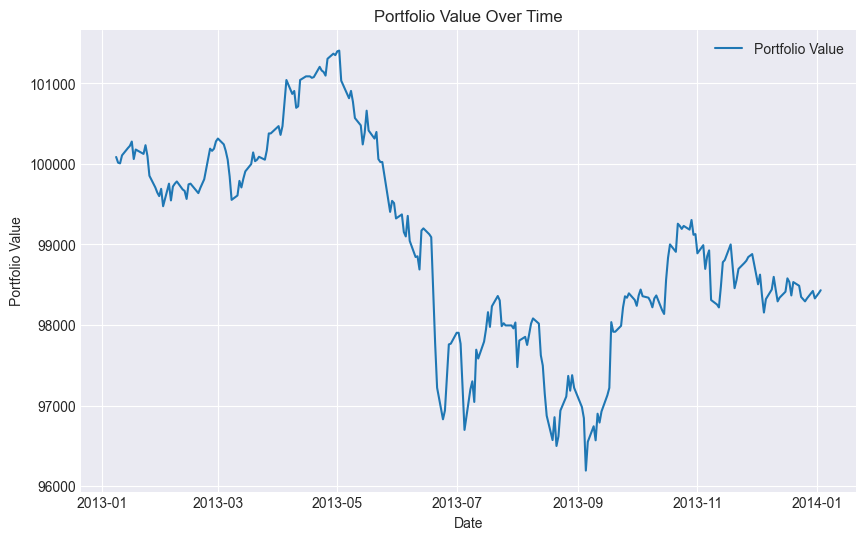

Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.5016
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.3377
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.1611
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: -0.0161
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: -0.1824
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: -0.3285
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: -0.4502
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: -0.5482
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: -0.6257
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: -0.6865
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: -0.7341
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: -0.7714
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: -0.8005
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: -0.8230
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: -0.8403
Epoch 1

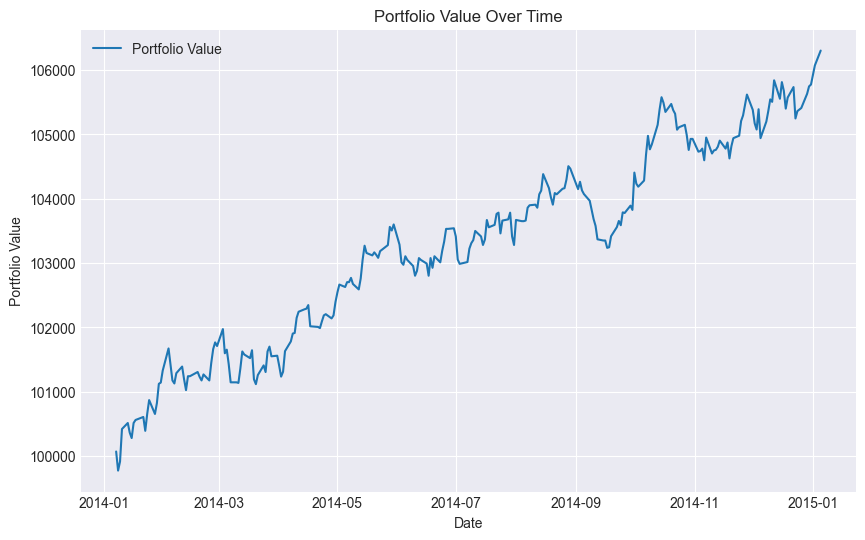

Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1.0068
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.9472
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.8789
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.8003
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.7087
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.6013
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.4751
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.3275
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.1562
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: -0.0389
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: -0.2532
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: -0.4755
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: -0.6900
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: -0.8808
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: -1.0373
Epoch 16/100


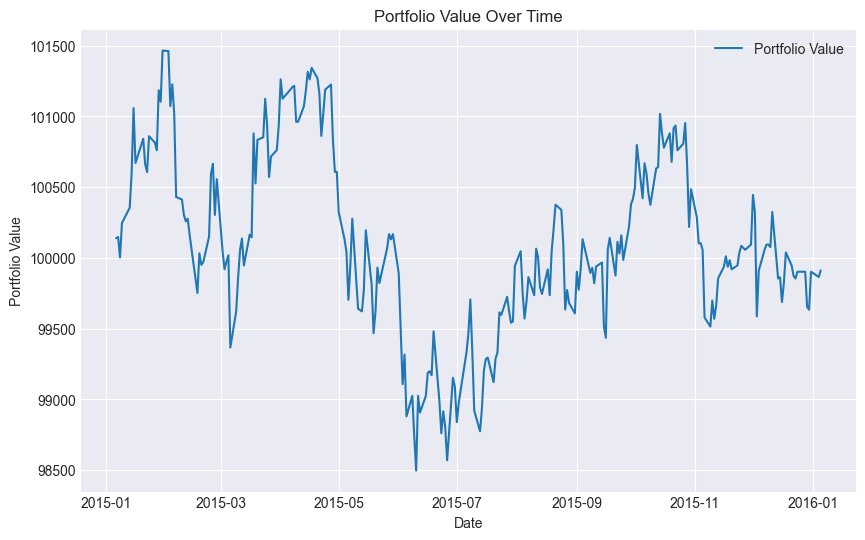

Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.9714
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.8666
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.7787
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.7067
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.6484
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.6011
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.5628
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.5318
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.5068
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.4869
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.4713
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.4592
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.4500
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.4431
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.4378
Epoch 16/100
1/1 ━━

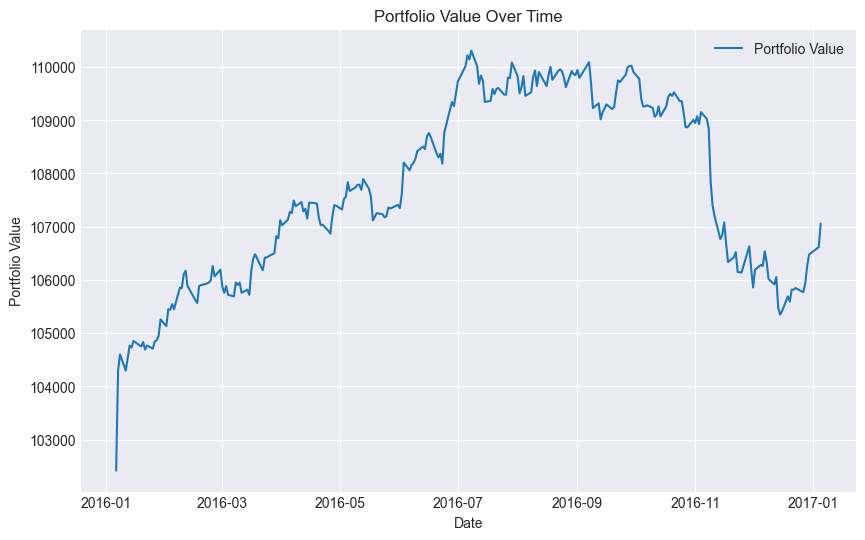

Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.7218
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.6917
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.6639
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.6395
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.6187
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.6016
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.5878
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.5771
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.5691
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.5634
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.5597
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.5570
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.5548
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.5524
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.5493
Epoch 16/100
1/1 ━━

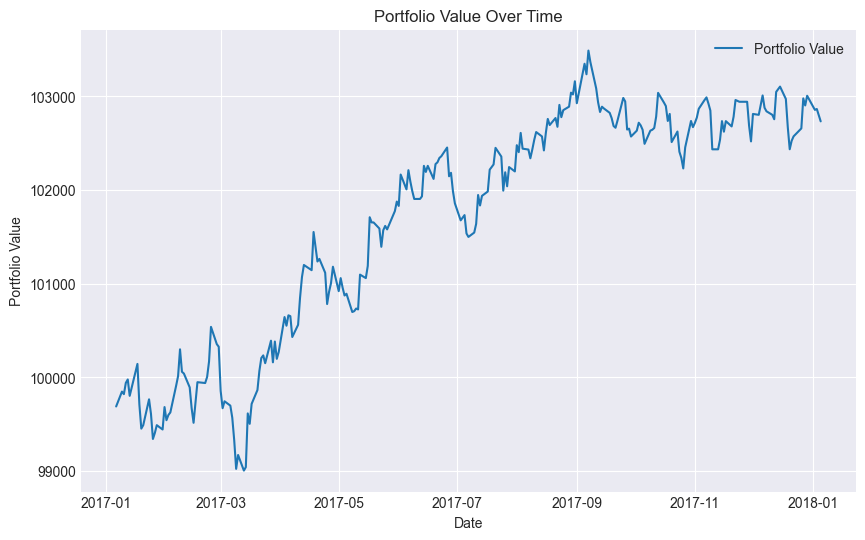

Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.5726
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.4534
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.3102
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.1394
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: -0.0606
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: -0.2877
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: -0.5294
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: -0.7637
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: -0.9664
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: -1.1234
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: -1.2350
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: -1.3095
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: -1.3566
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: -1.3848
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: -1.4005
Epoch 16

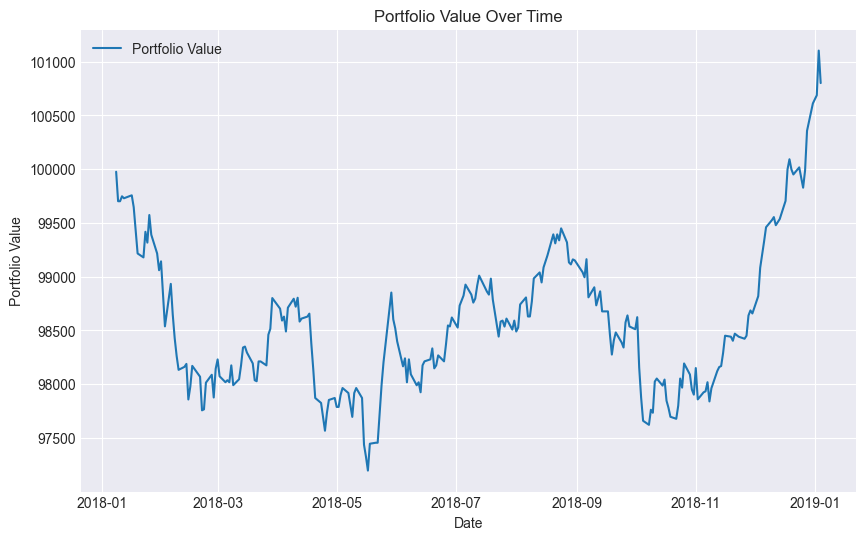

Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2624
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.2117
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.1534
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.0928
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0343
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: -0.0197
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: -0.0683
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: -0.1118
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: -0.1505
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: -0.1849
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: -0.2154
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: -0.2421
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: -0.2652
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: -0.2847
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: -0.3010
Epoch 16/

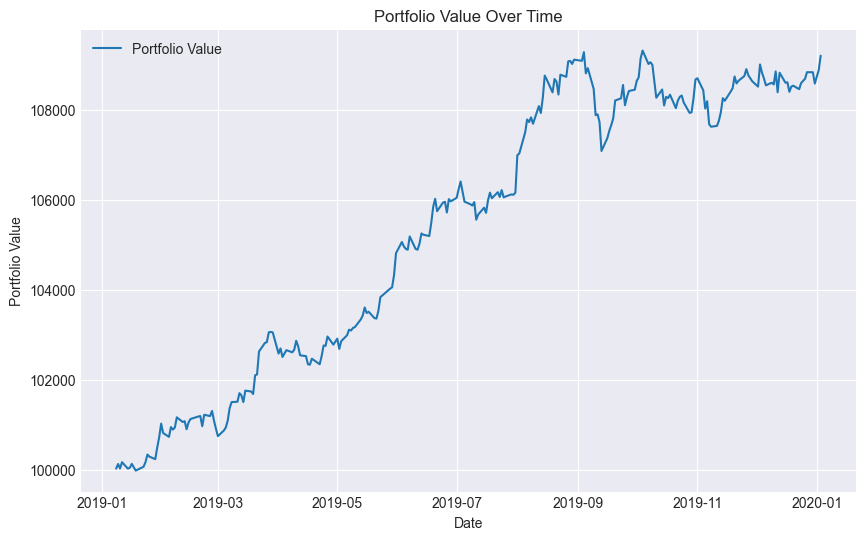

LSTM Results: [{'train_period': (Timestamp('2011-01-04 00:00:00'), Timestamp('2013-01-04 00:00:00')), 'test_period': (Timestamp('2013-01-05 00:00:00'), Timestamp('2014-01-05 00:00:00')), 'metrics': {'Sharpe Ratio': -0.457330977403587, 'Sortino Ratio': -0.5854819988658985, 'Max Drawdown': 0.05142995100569256}}, {'train_period': (Timestamp('2012-01-04 00:00:00'), Timestamp('2014-01-04 00:00:00')), 'test_period': (Timestamp('2014-01-05 00:00:00'), Timestamp('2015-01-05 00:00:00')), 'metrics': {'Sharpe Ratio': 2.21513509184196, 'Sortino Ratio': 3.73039867491078, 'Max Drawdown': 0.012155352092980323}}, {'train_period': (Timestamp('2013-01-04 00:00:00'), Timestamp('2015-01-04 00:00:00')), 'test_period': (Timestamp('2015-01-05 00:00:00'), Timestamp('2016-01-05 00:00:00')), 'metrics': {'Sharpe Ratio': -0.04173710011514824, 'Sortino Ratio': -0.06219943521545671, 'Max Drawdown': 0.02924750742360556}}, {'train_period': (Timestamp('2014-01-04 00:00:00'), Timestamp('2016-01-04 00:00:00')), 'test_pe

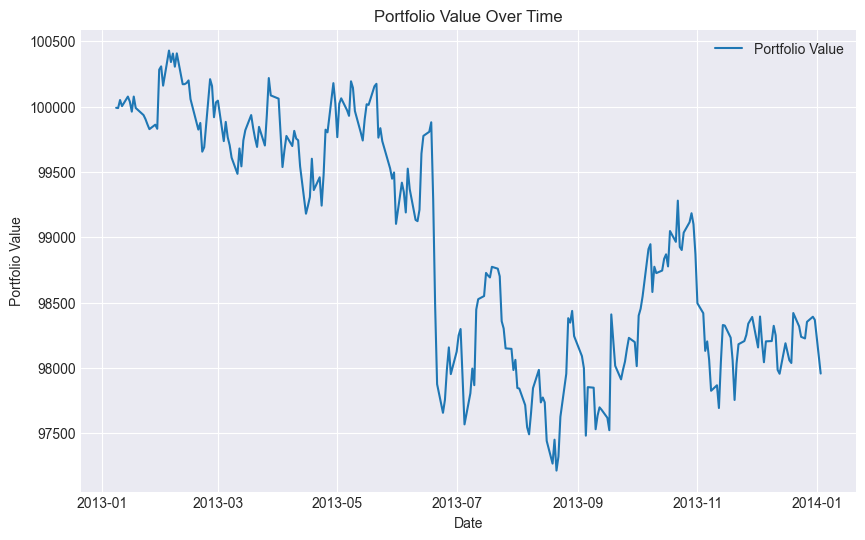

Asset Volatilities: Ticker
AGG     0.031522
DBC     0.180390
VIXY    0.598318
VTI     0.123900
Name: 2015-01-05 00:00:00, dtype: float64
Scaling Factors: Ticker
AGG     3.172437
DBC     0.554354
VIXY    0.167135
VTI     0.807106
Name: 2015-01-05 00:00:00, dtype: float64
Scaled and Normalized Weights: Ticker
AGG     0.674838
DBC     0.117922
VIXY    0.035553
VTI     0.171687
Name: 2015-01-05 00:00:00, dtype: float64


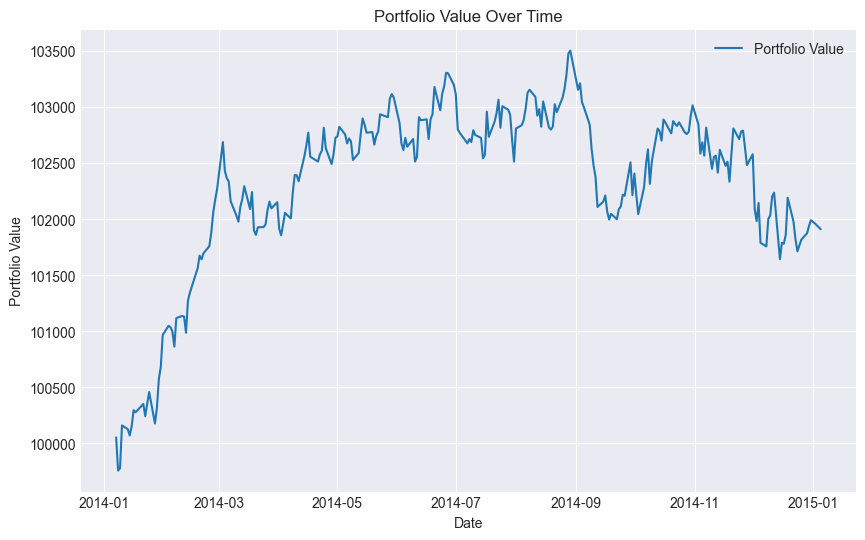

Asset Volatilities: Ticker
AGG     0.033326
DBC     0.162906
VIXY    0.791034
VTI     0.151150
Name: 2016-01-05 00:00:00, dtype: float64
Scaling Factors: Ticker
AGG     3.000655
DBC     0.613851
VIXY    0.126417
VTI     0.661593
Name: 2016-01-05 00:00:00, dtype: float64
Scaled and Normalized Weights: Ticker
AGG     0.681577
DBC     0.139432
VIXY    0.028715
VTI     0.150276
Name: 2016-01-05 00:00:00, dtype: float64


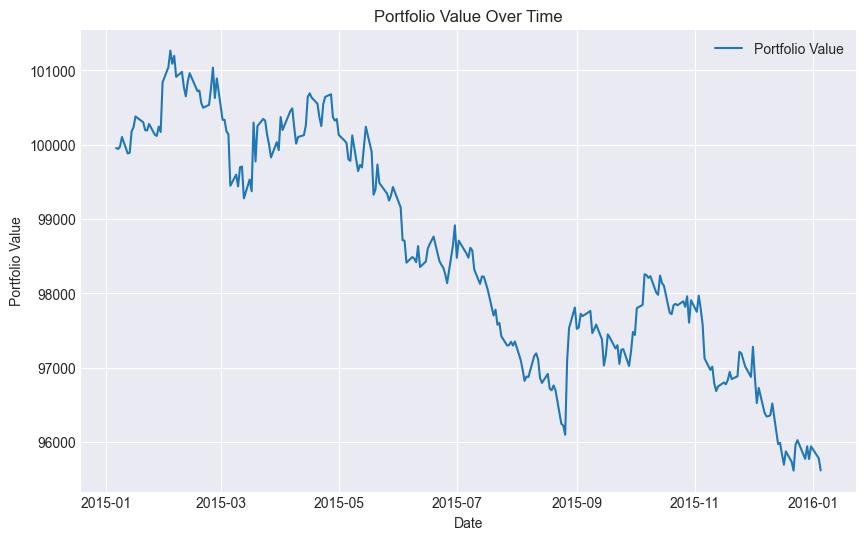

Asset Volatilities: Ticker
AGG     0.041374
DBC     0.162648
VIXY    0.501642
VTI     0.092566
Name: 2017-01-05 00:00:00, dtype: float64
Scaling Factors: Ticker
AGG     2.417006
DBC     0.614825
VIXY    0.199345
VTI     1.080309
Name: 2017-01-05 00:00:00, dtype: float64
Scaled and Normalized Weights: Ticker
AGG     0.560597
DBC     0.142602
VIXY    0.046236
VTI     0.250565
Name: 2017-01-05 00:00:00, dtype: float64


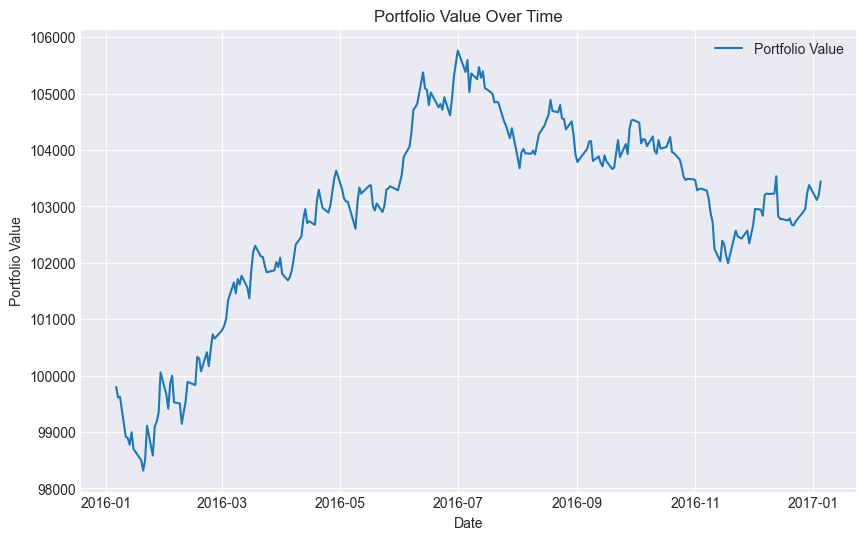

Asset Volatilities: Ticker
AGG     0.023325
DBC     0.108507
VIXY    0.308044
VTI     0.064036
Name: 2018-01-05 00:00:00, dtype: float64
Scaling Factors: Ticker
AGG     4.287198
DBC     0.921598
VIXY    0.324629
VTI     1.561634
Name: 2018-01-05 00:00:00, dtype: float64
Scaled and Normalized Weights: Ticker
AGG     0.604251
DBC     0.129893
VIXY    0.045754
VTI     0.220102
Name: 2018-01-05 00:00:00, dtype: float64


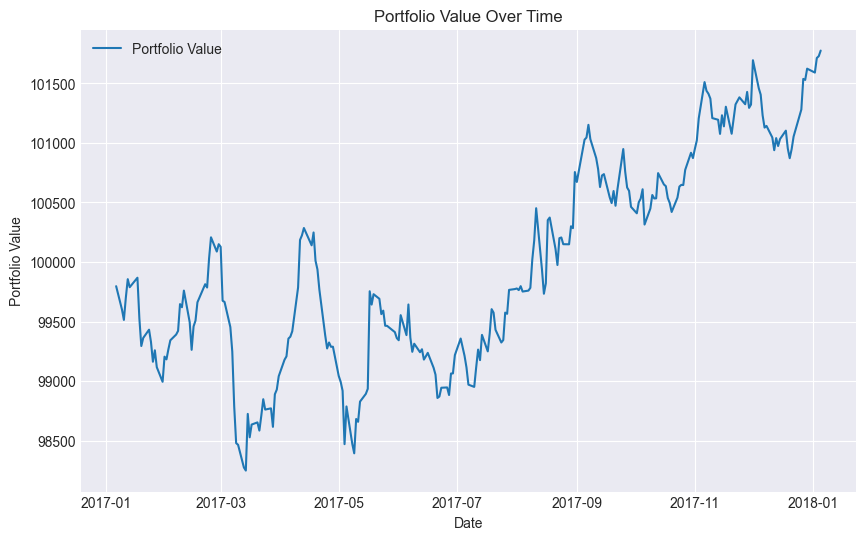

Asset Volatilities: Ticker
AGG     0.024475
DBC     0.185355
VIXY    0.714141
VTI     0.258217
Name: 2019-01-04 00:00:00, dtype: float64
Scaling Factors: Ticker
AGG     4.085825
DBC     0.539506
VIXY    0.140028
VTI     0.387271
Name: 2019-01-04 00:00:00, dtype: float64
Scaled and Normalized Weights: Ticker
AGG     0.792959
DBC     0.104705
VIXY    0.027176
VTI     0.075160
Name: 2019-01-04 00:00:00, dtype: float64


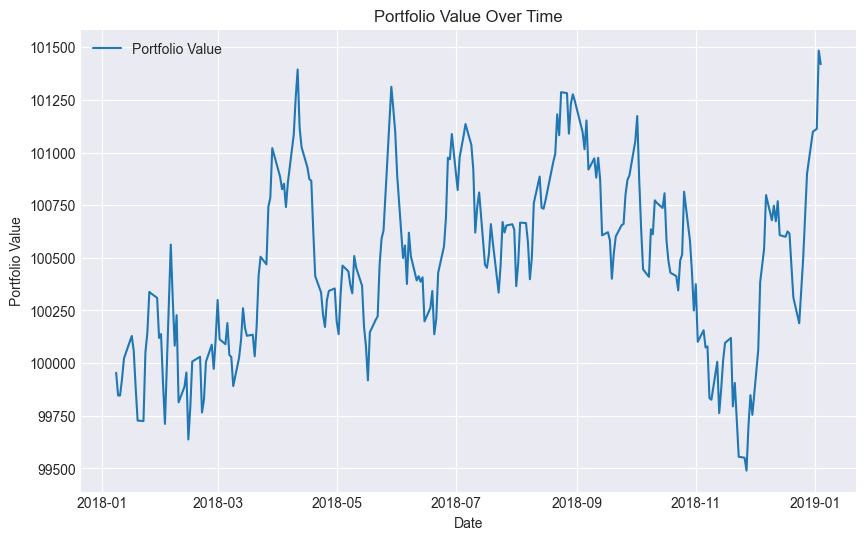

Asset Volatilities: Ticker
AGG     0.032831
DBC     0.112749
VIXY    0.434699
VTI     0.068738
Name: 2020-01-03 00:00:00, dtype: float64
Scaling Factors: Ticker
AGG     3.045881
DBC     0.886926
VIXY    0.230044
VTI     1.454802
Name: 2020-01-03 00:00:00, dtype: float64
Scaled and Normalized Weights: Ticker
AGG     0.542198
DBC     0.157882
VIXY    0.040950
VTI     0.258970
Name: 2020-01-03 00:00:00, dtype: float64


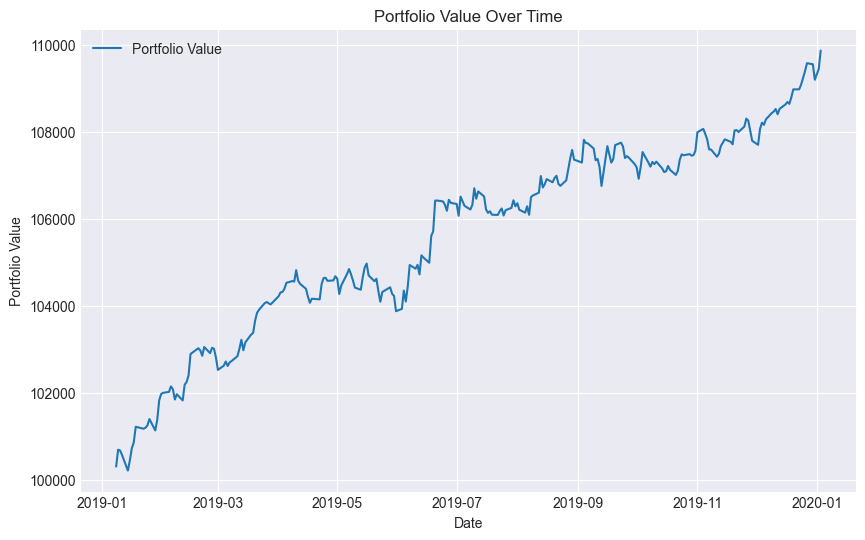

Equal-Weighted Results: [{'train_period': (Timestamp('2011-01-04 00:00:00'), Timestamp('2013-01-04 00:00:00')), 'test_period': (Timestamp('2013-01-05 00:00:00'), Timestamp('2014-01-05 00:00:00')), 'metrics': {'Sharpe Ratio': -0.5970454297880141, 'Sortino Ratio': -0.8959697703049347, 'Max Drawdown': 0.03201086198549119}}, {'train_period': (Timestamp('2012-01-04 00:00:00'), Timestamp('2014-01-04 00:00:00')), 'test_period': (Timestamp('2014-01-05 00:00:00'), Timestamp('2015-01-05 00:00:00')), 'metrics': {'Sharpe Ratio': 0.7585073513041465, 'Sortino Ratio': 1.1161618868222831, 'Max Drawdown': 0.017982870781709508}}, {'train_period': (Timestamp('2013-01-04 00:00:00'), Timestamp('2015-01-04 00:00:00')), 'test_period': (Timestamp('2015-01-05 00:00:00'), Timestamp('2016-01-05 00:00:00')), 'metrics': {'Sharpe Ratio': -1.1860511448701176, 'Sortino Ratio': -1.9430267287548666, 'Max Drawdown': 0.055821211322205196}}, {'train_period': (Timestamp('2014-01-04 00:00:00'), Timestamp('2016-01-04 00:00:0

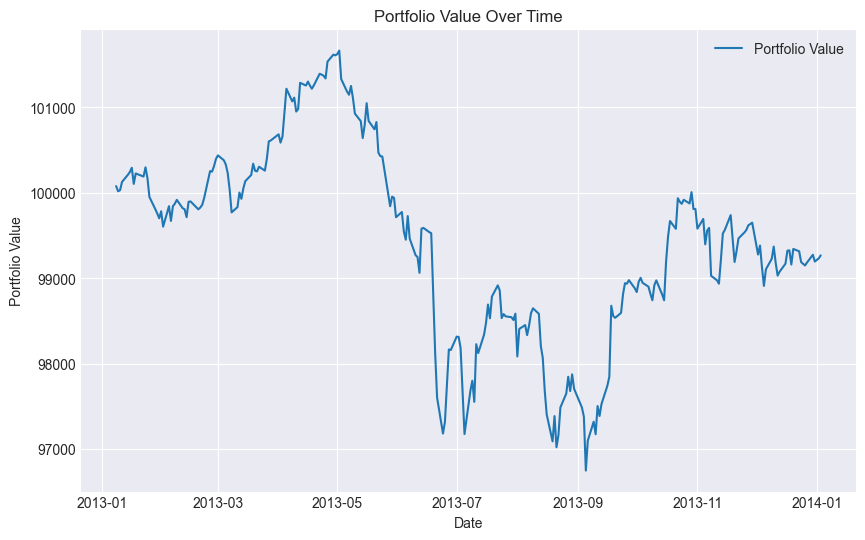

Asset Volatilities: Ticker
AGG     0.031522
DBC     0.180390
VIXY    0.598318
VTI     0.123900
Name: 2015-01-05 00:00:00, dtype: float64
Scaling Factors: Ticker
AGG     3.172437
DBC     0.554354
VIXY    0.167135
VTI     0.807106
Name: 2015-01-05 00:00:00, dtype: float64
Scaled and Normalized Weights: Ticker
AGG     8.197052e-01
DBC     9.725961e-16
VIXY    0.000000e+00
VTI     1.802948e-01
Name: 2015-01-05 00:00:00, dtype: float64


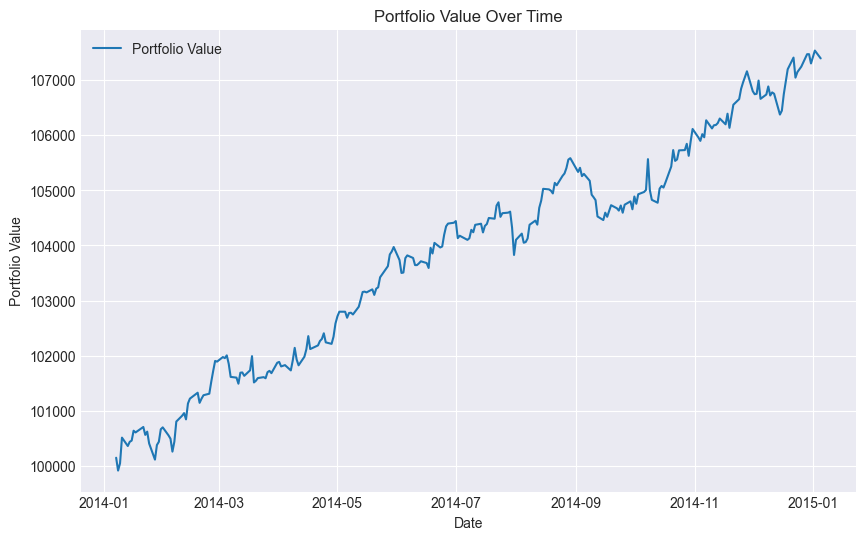

Asset Volatilities: Ticker
AGG     0.033326
DBC     0.162906
VIXY    0.791034
VTI     0.151150
Name: 2016-01-05 00:00:00, dtype: float64
Scaling Factors: Ticker
AGG     3.000655
DBC     0.613851
VIXY    0.126417
VTI     0.661593
Name: 2016-01-05 00:00:00, dtype: float64
Scaled and Normalized Weights: Ticker
AGG     6.792598e-01
DBC     2.015017e-13
VIXY    1.598908e-03
VTI     3.191413e-01
Name: 2016-01-05 00:00:00, dtype: float64


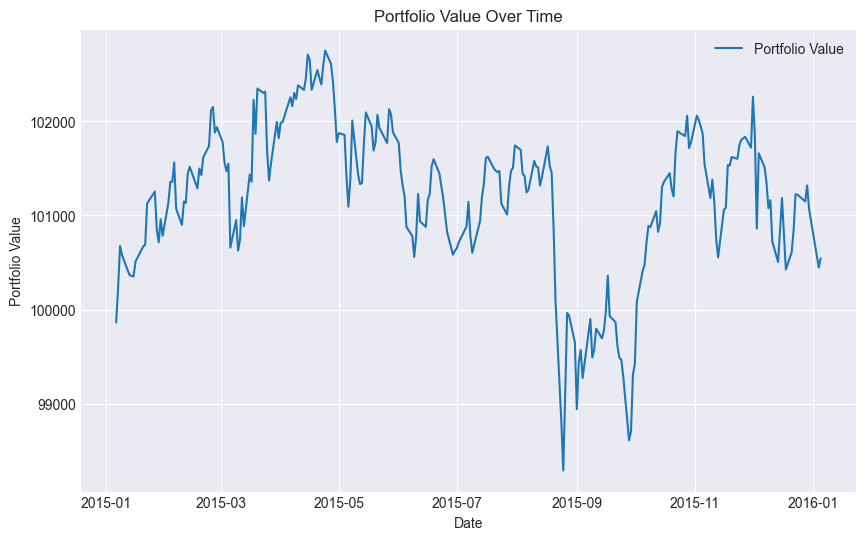

Asset Volatilities: Ticker
AGG     0.041374
DBC     0.162648
VIXY    0.501642
VTI     0.092566
Name: 2017-01-05 00:00:00, dtype: float64
Scaling Factors: Ticker
AGG     2.417006
DBC     0.614825
VIXY    0.199345
VTI     1.080309
Name: 2017-01-05 00:00:00, dtype: float64
Scaled and Normalized Weights: Ticker
AGG     9.176610e-01
DBC     1.882656e-16
VIXY    5.587570e-17
VTI     8.233903e-02
Name: 2017-01-05 00:00:00, dtype: float64


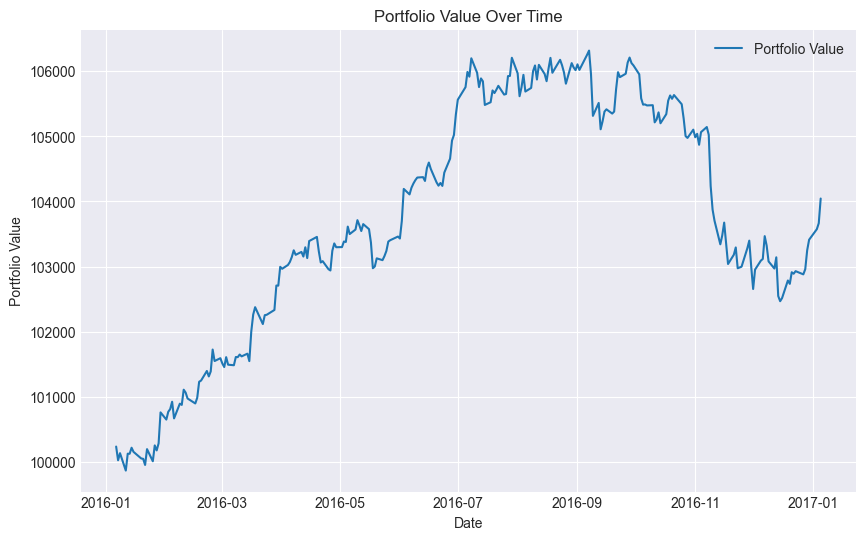

Asset Volatilities: Ticker
AGG     0.023325
DBC     0.108507
VIXY    0.308044
VTI     0.064036
Name: 2018-01-05 00:00:00, dtype: float64
Scaling Factors: Ticker
AGG     4.287198
DBC     0.921598
VIXY    0.324629
VTI     1.561634
Name: 2018-01-05 00:00:00, dtype: float64
Scaled and Normalized Weights: Ticker
AGG     0.893204
DBC     0.000000
VIXY    0.000000
VTI     0.106796
Name: 2018-01-05 00:00:00, dtype: float64


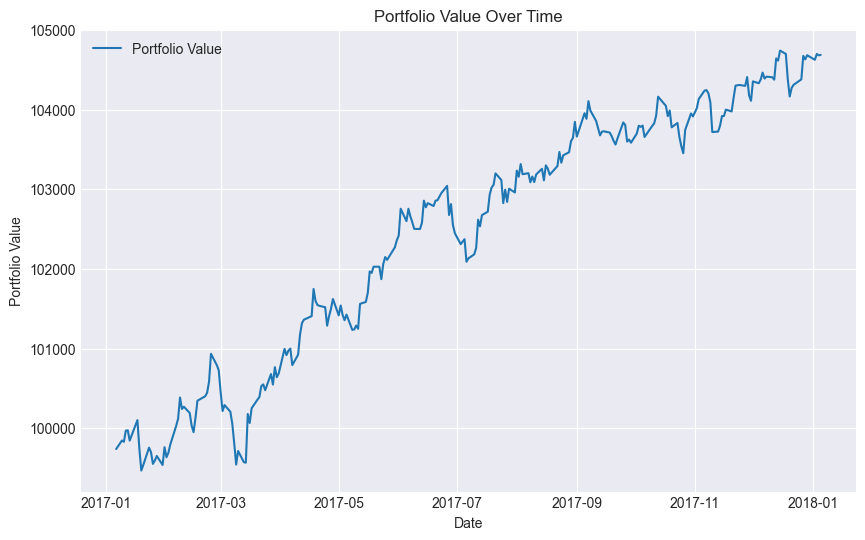

Asset Volatilities: Ticker
AGG     0.024475
DBC     0.185355
VIXY    0.714141
VTI     0.258217
Name: 2019-01-04 00:00:00, dtype: float64
Scaling Factors: Ticker
AGG     4.085825
DBC     0.539506
VIXY    0.140028
VTI     0.387271
Name: 2019-01-04 00:00:00, dtype: float64
Scaled and Normalized Weights: Ticker
AGG     8.188881e-01
DBC     1.410156e-02
VIXY    5.268246e-15
VTI     1.670103e-01
Name: 2019-01-04 00:00:00, dtype: float64


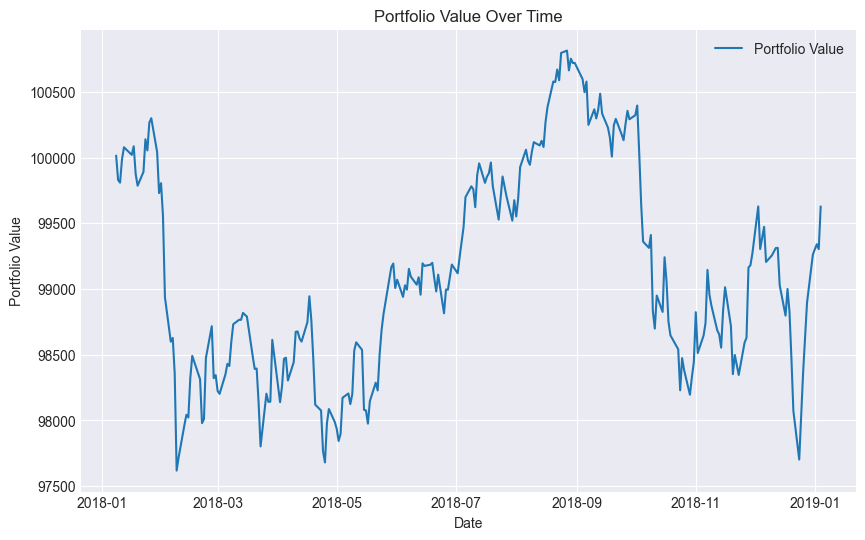

Asset Volatilities: Ticker
AGG     0.032831
DBC     0.112749
VIXY    0.434699
VTI     0.068738
Name: 2020-01-03 00:00:00, dtype: float64
Scaling Factors: Ticker
AGG     3.045881
DBC     0.886926
VIXY    0.230044
VTI     1.454802
Name: 2020-01-03 00:00:00, dtype: float64
Scaled and Normalized Weights: Ticker
AGG     8.294696e-01
DBC     2.400319e-14
VIXY    2.251830e-03
VTI     1.682786e-01
Name: 2020-01-03 00:00:00, dtype: float64


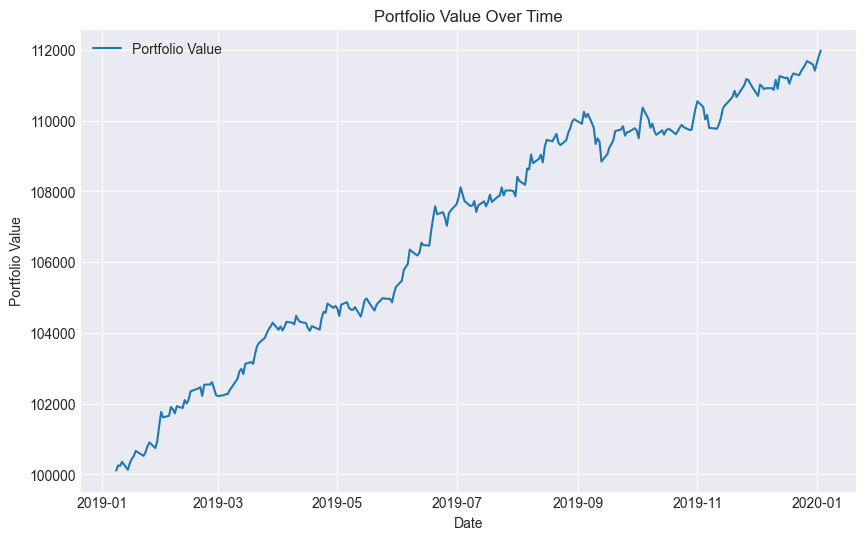

Mean-Variance Optimization Results: [{'train_period': (Timestamp('2011-01-04 00:00:00'), Timestamp('2013-01-04 00:00:00')), 'test_period': (Timestamp('2013-01-05 00:00:00'), Timestamp('2014-01-05 00:00:00')), 'metrics': {'Sharpe Ratio': -0.21807675222448375, 'Sortino Ratio': -0.282476657320192, 'Max Drawdown': 0.04837730631949906}}, {'train_period': (Timestamp('2012-01-04 00:00:00'), Timestamp('2014-01-04 00:00:00')), 'test_period': (Timestamp('2014-01-05 00:00:00'), Timestamp('2015-01-05 00:00:00')), 'metrics': {'Sharpe Ratio': 2.782930760236905, 'Sortino Ratio': 3.997560583855133, 'Max Drawdown': 0.010619884395636457}}, {'train_period': (Timestamp('2013-01-04 00:00:00'), Timestamp('2015-01-04 00:00:00')), 'test_period': (Timestamp('2015-01-05 00:00:00'), Timestamp('2016-01-05 00:00:00')), 'metrics': {'Sharpe Ratio': 0.1660297430378572, 'Sortino Ratio': 0.243654506043682, 'Max Drawdown': 0.043425507474479215}}, {'train_period': (Timestamp('2014-01-04 00:00:00'), Timestamp('2016-01-04 

In [ ]:
# Define tickers and data parameters
tickers = ['VTI', 'AGG', 'DBC', 'VIXY']
data = get_data(tickers, '2006-01-02', '2021-01-04')

# Rolling validation with LSTM-based optimization (with periodic rebalancing)
lstm_results = generalized_rolling_validation(data, train_and_rebalance_portfolio)
print("LSTM Results:", lstm_results)

# Rolling validation with mean-variance optimization
mvo_results = generalized_rolling_validation(data, mean_variance_optimized_strategy)
print("Mean-Variance Optimization Results:", mvo_results)
